In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

Read the financial data

In [3]:
df = pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')

In [4]:
df.shape

(6362620, 11)

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Explanation provided by dataset creators**:-

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

Renaming the name of columns to more descriptive one. 
* old_balance_orig_cus - Balance of original account before transaction, 
* new_balance_orig_cus - Balance of original account after transaction, 
* old_balance_rec_cus - Balance of destination account before receiving the transaction, 
* new_balance_rec_cus - Balance of destination account after receiving the transaction, 
* orig_cus_name - Account holder name of original account,
* rec_cus_name - Account holder name of destination account,
* is_fraud - Target variable, 
* is_flagged_fraud - Whether the transaction has been flagged fraud or not based on the rule "whether transaction amount is greater than 200,000"

In [6]:
df = df.rename(columns={'oldbalanceOrg': 'old_balance_orig_cus', 'newbalanceOrig': 'new_balance_orig_cus',
                       'oldbalanceDest': 'old_balance_rec_cus', 'newbalanceDest': 'new_balance_rec_cus',
                       'nameOrig': 'orig_cus_name', 'nameDest': 'rec_cus_name', 'isFraud': 'is_fraud',
                       'isFlaggedFraud': 'is_flagged_fraud'})

In [7]:
df.head()

,step,type,amount,orig_cus_name,old_balance_orig_cus,new_balance_orig_cus,rec_cus_name,old_balance_rec_cus,new_balance_rec_cus,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Checking for null values in each column

In [8]:
for col in df.columns:
    if (df[col].isnull().sum() > 0):
        print(col)

Changing the name of columns to lower case

In [9]:
df.columns = df.columns.str.lower()

In [10]:
df.head()

,step,type,amount,orig_cus_name,old_balance_orig_cus,new_balance_orig_cus,rec_cus_name,old_balance_rec_cus,new_balance_rec_cus,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [83]:
# Number of Fraud Transactions
len(df[df['is_fraud']==1])

8213

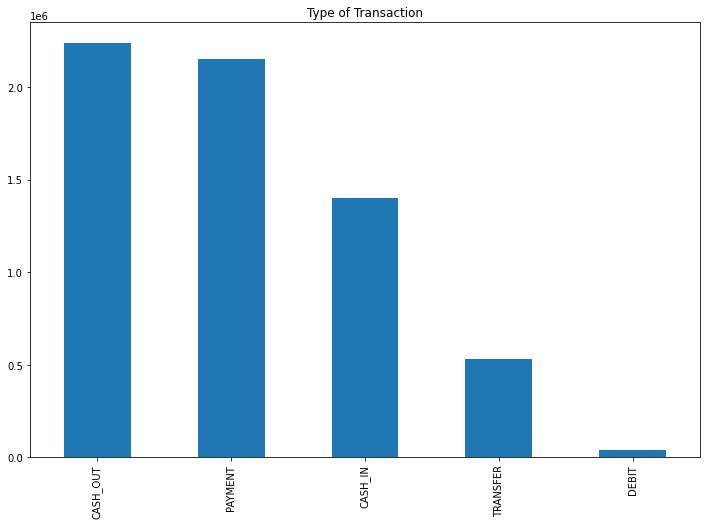

In [11]:
f, ax = plt.subplots(1,1, figsize=(8,8))
# plotting the number of different types of values present in type column
df.type.value_counts().plot(kind='bar', 
        title="Type of Transaction", ax=ax, figsize=(12,8))
plt.show()

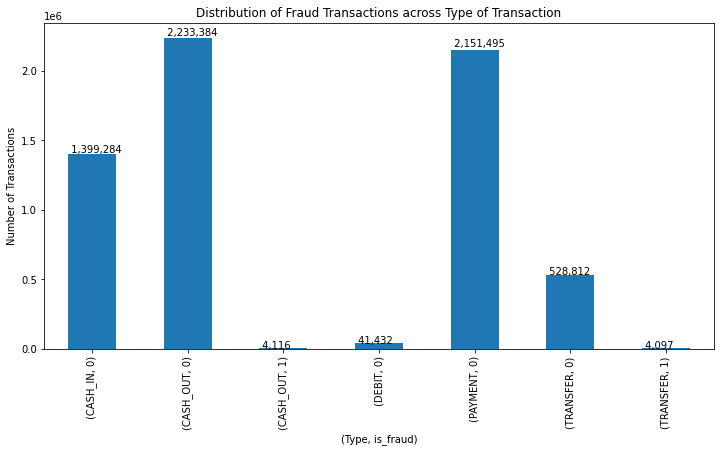

In [12]:
from matplotlib.pyplot import figure
# setting the size of figure
figure(figsize=(12, 6))
# grouping data points based on the values present in columns "type" and target variable "is_fraud"
ax = df.groupby(['type', 'is_fraud']).size().plot(kind='bar')
# setting the title of plot
ax.set_title("Distribution of Fraud Transactions across Type of Transaction")
# setting the label name of x label
ax.set_xlabel("(Type, is_fraud)")
# setting the label name of y label
ax.set_ylabel("Number of Transactions")
# getting the height of each and every bar plot, and annotating the plot with that value
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ' ,d')), 
                (p.get_x(), p.get_height()*1.01))

Fraud transactions have occured in only two type of transactions, which are
* when cash is taken out - "CASH_OUT"
* or when cash is transferred - "TRANSFER"

In [13]:
df[df['is_fraud']==1].type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [14]:
df[df['is_fraud']==1]['amount'].max()

10000000.0

In [15]:
df[df['is_fraud']==1]['amount'].min()

0.0

* "isFlaggedFraud" variable - The financial institution tries to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.
* Whenever transaction amount > 200,000, is_flagged_fraud == 1, else 0

In [16]:
len(df[df['is_flagged_fraud']==1])

16

There are 16 instances when is_flagged_fraud is 1.

In [17]:
df[df['is_flagged_fraud']==1].type.value_counts()

TRANSFER    16
Name: type, dtype: int64

Whenever is_flagged_fraud == 1, the type of transaction is always "TRANSFER"

In [18]:
df[df['is_flagged_fraud']==1]['amount'].value_counts()

10000000.00    3
4953893.08     1
1343002.08     1
536624.41      1
4892193.09     1
9585040.37     1
3576297.10     1
353874.22      1
2542664.27     1
399045.08      1
3441041.46     1
3171085.59     1
7316255.05     1
5674547.89     1
Name: amount, dtype: int64

Always the amount is greater than 200,000 whenever is_flagged_fraud is 1. This justifies their claim.

In [19]:
df_transfer = df.loc[df.type == 'TRANSFER']
df_not_flagged = df.loc[df.is_flagged_fraud == 0]

df_transfer.loc[df_transfer.is_flagged_fraud == 0].amount.max()

92445516.64

But there are instances when amount is greater than 200,000 but these transactions are not flagged. So in such scenarios the credibility of variable "is_flagged_fraud" is in jeopardy.

In [20]:
(df_transfer[df_transfer['is_flagged_fraud']==0]['amount'] > 200000).sum()/len(df_transfer['is_flagged_fraud']==0)

0.7676620210955342

So whenever is_flagged_fraud is 0, 76% of the time the amount is more than 200000. So fraud is not flagged 76% of the time, when it is actually a fraud by definition.

**Although "is_fraud" is always set when "is_flagged_fraud" is set, since
"is_flagged_fraud" is set just 16 times in a seemingly meaningless way, we 
can treat this feature as insignificant and discard it in the dataset 
without loosing information**

In [21]:
df['orig_cus_name_initial'] = df['orig_cus_name'].astype(str).str[0]
df['rec_cus_name_initial'] = df['rec_cus_name'].astype(str).str[0]

* orig_cus_name_initial - it stores first letter of the customer name. If it is "C" -> then the original customer is a customer, if it is "M" -> then the original customer is a merchant.
* rec_cus_name_initial - it stores first letter of receiving customer name. 

In [22]:
df['orig_cus_name_initial'].value_counts()

C    6362620
Name: orig_cus_name_initial, dtype: int64

**Transactions are always initiated by customer**

In [23]:
df['rec_cus_name_initial'].value_counts()

C    4211125
M    2151495
Name: rec_cus_name_initial, dtype: int64

While at the receiving end there could be customer or merchant. We don't have any information of old balance and new balance of merchants.

Fraudulent transactions are not indicated by original customer name or receiving customer name.

In [24]:
df['orig_cus_name'].nunique(), df['rec_cus_name'].nunique()

(6353307, 2722362)

These huge number of unique categorical variables can't be encoded. So we will be dropping these features.

In [25]:
df['orig_cus_name'].value_counts().sort_values()

C627667781     1
C1318395825    1
C464831537     1
C693982422     1
C78109530      1
              ..
C2051359467    3
C1065307291    3
C1530544995    3
C1999539787    3
C1902386530    3
Name: orig_cus_name, Length: 6353307, dtype: int64

In [26]:
df['rec_cus_name'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: rec_cus_name, Length: 2722362, dtype: int64

There is a huge variety and number of unique values present in names of customer so they could not be encoded, or grouped together and encoded(rare encoding). Due to computational inefficiency and time constraint too, encoding them is tough.

**Data Cleaning**

From EDA, we know that fraud only occurs in "TRANSFER" and "CASH_OUT" type. So we assemble only the corresponding data in X for analysis.

In [27]:
data = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
# setting the seed to ensure reproducibility of results
np.random.seed(192)
# y is the traget variable
y = data['is_fraud']
# X contains the input
X = data.drop(columns=['is_fraud'])
# Dropping categorical and useless column from input features
X = X.drop(columns= ['orig_cus_name', 'rec_cus_name',
                     'is_flagged_fraud'])
# Encoding "type" column. Whenever type == Transfer, it is 1 else it is 0
X['type'] = np.where(X['type']=='TRANSFER', 0, 1)
# Converting this categorical column to integer type
X['type'] = X['type'].astype(int)

In [28]:
X.head()

,step,type,amount,old_balance_orig_cus,new_balance_orig_cus,old_balance_rec_cus,new_balance_rec_cus,orig_cus_name_initial,rec_cus_name_initial
2,1,0,181.00,181.0,0.0,0.0,0.00,C,C
3,1,1,181.00,181.0,0.0,21182.0,0.00,C,C
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,C,C
19,1,0,215310.30,705.0,0.0,22425.0,0.00,C,C
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,C,C


In [29]:
# Dropping this feature as it is constant all the time, and won't help in improving the model
X = X.drop(columns=['orig_cus_name_initial'])

In [30]:
# Encoding receiving customer name starting with C as 0, else 1
X['rec_cus_name_initial'] = np.where(X['rec_cus_name_initial']=='C', 0, 1)
# Converting this categorical column to numerical
X['rec_cus_name_initial'] = X['rec_cus_name_initial'].astype(int)

In [31]:
# Checking data type of inputs, all are numerical values now
X.dtypes

step                      int64
type                      int64
amount                  float64
old_balance_orig_cus    float64
new_balance_orig_cus    float64
old_balance_rec_cus     float64
new_balance_rec_cus     float64
rec_cus_name_initial      int64
dtype: object

In [32]:
# checking data type of target variable too
y.dtypes

dtype('int64')

In [33]:
X['error_balance_orig_cus'] = X['new_balance_orig_cus'] + X['amount'] - X['old_balance_orig_cus']
X['error_balance_rec_cus'] = X['old_balance_rec_cus'] + X['amount'] - X['new_balance_rec_cus']

* These variables represent error in balance of original and receiving customer. This variable came out to be an important feature from previous kernel so including it.

In [34]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2, random_state=192)

In [81]:
sum(y_train.values == 1)/len(y_train)

0.002969778376566274

In [82]:
sum(y_test.values == 1)/len(y_test)

0.00294360762486419

In [35]:
# the scaler - for robust scaling
from sklearn.preprocessing import Normalizer

# set up the scaler 
scaler = Normalizer(norm='l1')
# reset the index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
# fit the scaler
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# transform numpy arrays to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,
                            columns=X_test.columns)
# crete a new dataframe which contains only the scaled features
X_train_scaled.columns = [str(col) + '_scaled' for col in 
                          X_train_scaled.columns]
X_test_scaled.columns = [str(col) + '_scaled' for col in 
                          X_test_scaled.columns]
# Finally concatenating the normal and scaled features.
X_train = pd.concat([X_train.reset_index(drop=True),
                          X_train_scaled.reset_index(drop=True)],
                         axis=1)
X_test = pd.concat([X_test.reset_index(drop=True),
                         X_test_scaled.reset_index(drop=True)],
                        axis=1)
X_train.shape, X_test.shape

((2216327, 20), (554082, 20))

Cheking for null values in each column of train and test data.

In [36]:
for col in X_train.columns:
    if X_train[col].isnull().sum()>0:
        print(col)

In [37]:
for col in X_test.columns:
    if X_test[col].isnull().sum()>0:
        print(col)

In [38]:
# remove constant and quasi-constant features

quasi_constant_feat = []

for feature in X_train.columns:
    # seeing the type of values present in each column
    predominant = (X_train[feature].value_counts()/np.float(
        len(X_train))).sort_values(ascending=False).values[
        0]
    # if a column is filled with same value 99.8% of the time, then those columns are quasi constant
    if predominant > 0.998:
        quasi_constant_feat.append(feature)
# quasi constant columns may reduce the accuracy of our model so removing them from input        
X_train.drop(columns=quasi_constant_feat, inplace=True)
X_test.drop(columns=quasi_constant_feat, inplace=True)

In [39]:
quasi_constant_feat

['rec_cus_name_initial', 'rec_cus_name_initial_scaled']

In [40]:
# shape of train and test data after removing constant and quasi constant features
X_train.shape, X_test.shape

((2216327, 18), (554082, 18))

In [41]:
# remove duplicated features

duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i%10 == 0:
        # printing i to see where the loop is currently iterating
        print(i)
        
    col_1 = X_train.columns[i]
    for col_2 in X_train.columns[i+1:]:
        # if two columns are duplicates of each other, then storing the name of second columnin duplicated_feat
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
# dropping duplicated features            
X_train.drop(columns=duplicated_feat, inplace=True)
X_test.drop(columns=duplicated_feat, inplace=True)
X_train.shape, X_test.shape

0
10


((2216327, 18), (554082, 18))

In [42]:
# remove correlated features to reduce the feature space

def correlation(dataset, threshold):
    # set of all the names of correlated columns
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # if two columns are correlated more than threshold value, then storing those columns
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
# the threshold value is 0.8
corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)))

# if two columns are correlated to each other more than 80%, then dropping one of them
X_train = X_train.drop(columns=corr_features)
X_test = X_test.drop(columns=corr_features)
X_train.shape, X_test.shape

correlated features:  4


((2216327, 14), (554082, 14))

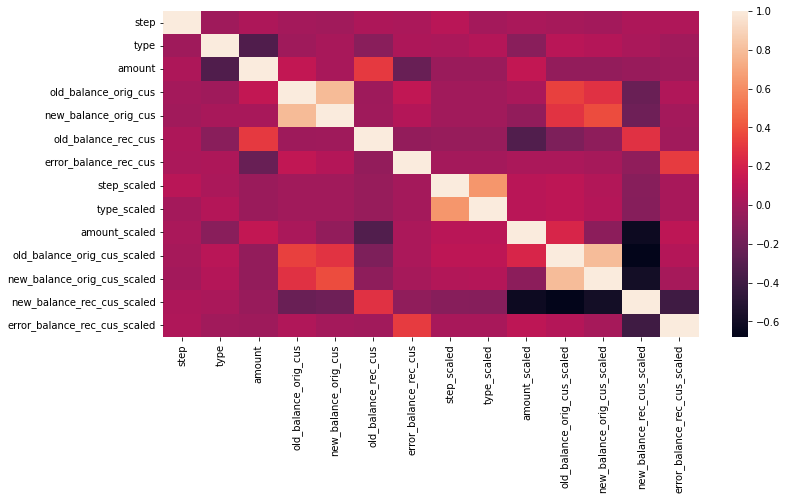

In [49]:
from matplotlib.pyplot import figure
# setting the size of figure
figure(figsize=(12, 6))
dataplot = sns.heatmap(X_train.corr())
plt.show()

In [43]:
corr_features

{'error_balance_orig_cus',
 'error_balance_orig_cus_scaled',
 'new_balance_rec_cus',
 'old_balance_rec_cus_scaled'}

In [44]:
X_train.head()

,step,type,amount,old_balance_orig_cus,new_balance_orig_cus,old_balance_rec_cus,error_balance_rec_cus,step_scaled,type_scaled,amount_scaled,old_balance_orig_cus_scaled,new_balance_orig_cus_scaled,new_balance_rec_cus_scaled,error_balance_rec_cus_scaled
0,181,0,159455.68,41098.0,0.0,892562.91,0.00,0.000080,0.000000e+00,0.070441,0.018155,0.000000,0.464739,0.000000e+00
1,157,0,243738.00,0.0,0.0,708406.29,112690.57,0.000073,0.000000e+00,0.113462,0.000000,0.000000,0.390774,5.245854e-02
2,356,0,422174.92,7830.0,0.0,0.00,0.00,0.000281,0.000000e+00,0.333240,0.006181,0.000000,0.333240,0.000000e+00
3,304,1,155933.27,0.0,0.0,2101464.64,0.01,0.000065,2.140854e-07,0.033383,0.000000,0.000000,0.483276,2.140854e-09
4,375,1,152304.10,252972.0,100667.9,2756971.82,0.00,0.000061,1.620071e-07,0.024674,0.040983,0.016309,0.471323,0.000000e+00


In [45]:
# we are using XG Boost classifier model
model = XGBClassifier()
y_pred = model.fit(X_train, y_train).predict_proba(X_test)
print('Test AUPRC = {}'.format(average_precision_score(y_test, y_pred[:,1])))

AUPRC = 0.9822038464784253


In [52]:
y_train_pred = model.predict_proba(X_train)
print('Train AUPRC = {}'.format(average_precision_score(y_train, y_train_pred[:,1])))

Train AUPRC = 0.9985625339176798


In [63]:
model.classes_

array([0, 1])

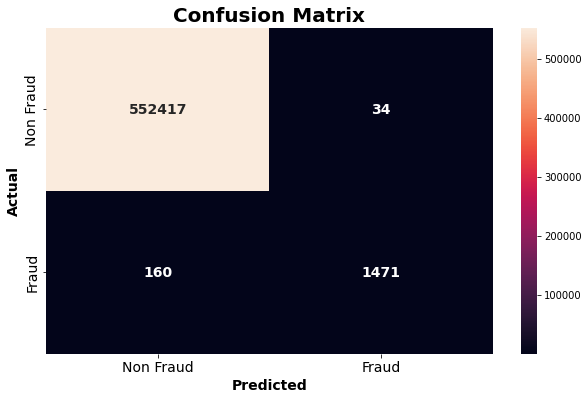

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pred_probability = model.predict(X_test)
predictions = pred_probability > 0.5

plt.figure(figsize=(10,6))
plt.title('Confusion Matrix', size=20, weight='bold')
sns.heatmap(
     confusion_matrix(y_test, pred_probability, labels=model.classes_),
     annot=True,
     annot_kws={'size':14, 'weight': 'bold'},
     fmt='d',
     xticklabels=['Non Fraud', 'Fraud'],
     yticklabels=['Non Fraud', 'Fraud'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [72]:
# 0 is non fraud and 1 is fraud
print(classification_report(y_test, pred_probability, labels=model.classes_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552451
           1       0.98      0.90      0.94      1631

    accuracy                           1.00    554082
   macro avg       0.99      0.95      0.97    554082
weighted avg       1.00      1.00      1.00    554082



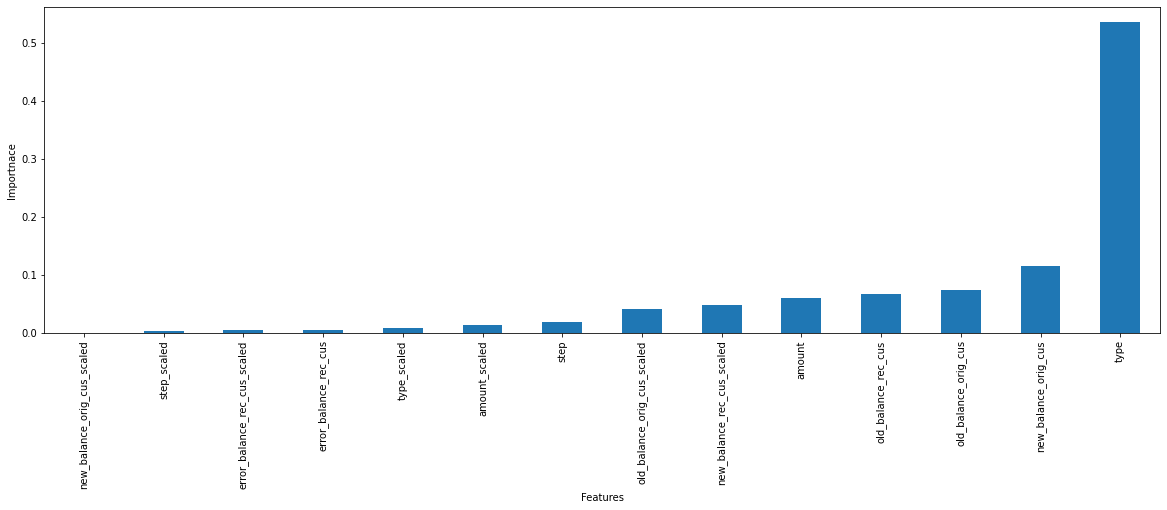

In [46]:
features = pd.Series(model.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importnace')
plt.show()

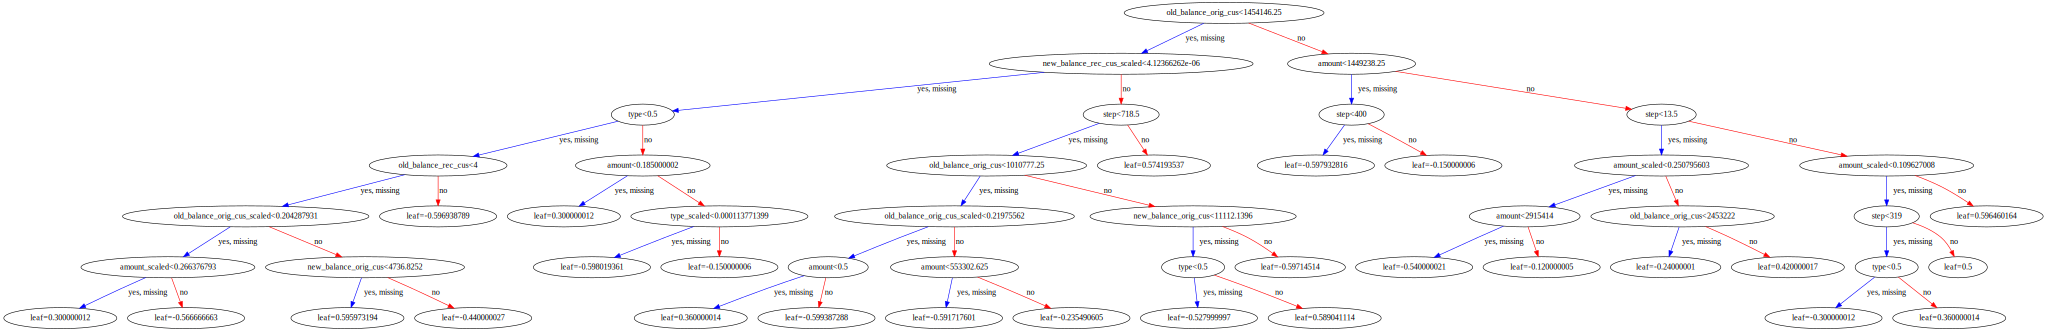

In [47]:
to_graphviz(model)